# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = '/workspace/DLND/data/__datasets/processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # DONE: Implement function and return a dataloader
    
    # transformations for data pre-process
    transform = transforms.Compose([transforms.Resize(image_size),
                                     transforms.ToTensor()])
    
    # create dataset via ImageFolder method
    train_dataset = datasets.ImageFolder(data_dir, transform)
    
    # create dataloader
    train_dataloader = DataLoader(dataset=train_dataset, 
                                  batch_size=batch_size,
                                  shuffle=True)
    
    return train_dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size, data_dir=data_dir)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

<ipython-input-6-13b4d9c7a4be>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


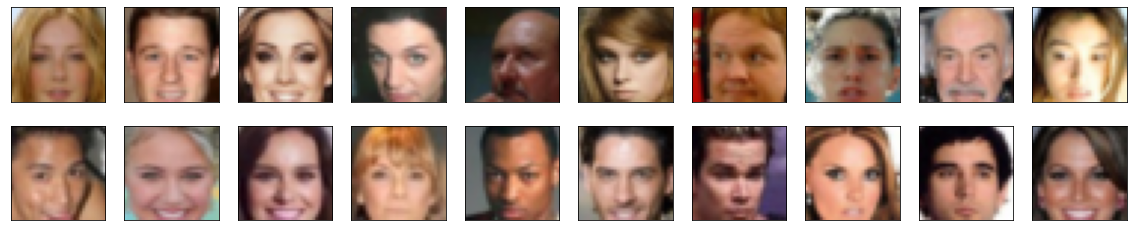

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# DONE: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    range_min, range_max = feature_range
    x = x*(range_max-range_min)+range_min
    
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9451)
Max:  tensor(0.9922)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper function for instantiating convolution and batch norm
def help_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates convolutional layer and optional batch normalization layer
    """
    out_layers=[]
    layer_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=False)
    
    out_layers.append(layer_conv)
    
    if batch_norm:
        out_layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*out_layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim=conv_dim
        
        # 3x32x32 --> (conv_dim)x16x16
        self.conv1 = help_conv(3, conv_dim, 4, batch_norm=False)
        # (conv_dim)x16x16 --> (conv_dim*2)x8x8
        self.conv2 = help_conv(conv_dim, conv_dim*2, 4)
        # (conv_dim*2)x8x8 --> (conv_dim*4)x4x4
        self.conv3 = help_conv(conv_dim*2, conv_dim*4, 4)
        # (conv_dim*4)x8x8 --> (conv_dim*8)x2x2
        self.conv3 = help_conv(conv_dim*4, conv_dim*8, 4)
        
        self.fc = nn.Linear((conv_dim*8)*2*2, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        x = torch.flatten(x, 1)
        
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
# helper function for instantiating de-convolution and batch norm
def help_t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """
    Creates transpose convolutional layer and optional batch normalization layer
    """
    out_layers=[]
    layer_t_conv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,
                                       kernel_size=kernel_size, stride=stride, padding=padding,
                                       bias=False)
    
    out_layers.append(layer_t_conv)
    
    if batch_norm:
        out_layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*out_layers)

In [18]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, (conv_dim*8)*2*2)
        
        # (conv_dim*8)x2x2 --> (conv_dim*4)x4x4
        self.t_conv1 = help_t_conv(conv_dim*8, conv_dim*4, 4)
        # (conv_dim*4)x4x4 --> (conv_dim*2)x8x8
        self.t_conv2 = help_t_conv(conv_dim*4, conv_dim*2, 4)
        # (conv_dim*2)x8x8 --> (conv_dim)x16x16
        self.t_conv3 = help_t_conv(conv_dim*2, conv_dim, 4)
        # (conv_dim)x16x16 --> 3x32x32
        self.t_conv4 = help_t_conv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.tanh(self.t_conv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1780: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [44]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # DONE: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [46]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Number of conv layers initialized: 1
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 1
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 1
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 1
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 1
Number of conv layers initialized: 1
Number of linear layers initialized: 0
Number of conv layers initialized: 0
Number of linear layers initialized: 0
Number of co

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [30]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    
    # generate vector of batch size with expected out values AND apply smoothing
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
    
    # Binary Cross Entropy With Logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    
    # generate vector of batch size with expected out values
    labels = torch.zeros(batch_size)
    # move labels to GPU if available
    if train_on_gpu:
        labels = labels.cuda()
    
    # Binary Cross Entropy With Logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [27]:
import torch.optim as optim

learning_rate = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [35]:
import time
from datetime import timedelta

def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_start_time = time.time()
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        epoch_start_time = time.time()
        
        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_optimizer.zero_grad()
            
            # ---- ---- ---- ----
            # move images to GPU if available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # compute discriminator losses on real images
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)
            
            # ---- ---- ---- ----
            # create vector for sampling
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            # ---- ---- ---- ----
            # generate images in generator using sampling vector
            fake_images = G(z)
            
            # ---- ---- ---- ----
            # compute discriminator losses on fake images
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)
            
            # ---- ---- ---- ----
            # Calculate total loss, backpropagation and optimizer step
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            
            # ===============================================
            # 2. Train the generator with an adversarial loss
            
            g_optimizer.zero_grad()
            
            # ---- ---- ---- ----
            # create vector for sampling
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            # ---- ---- ---- ----
            # generate images in generator using sampling vector
            fake_images = G(z)
            
            # ---- ---- ---- ----
            # compute discriminator losses on fake images with FLIPPED lables
            d_fake = D(fake_images)
            g_loss = real_loss(d_fake, True)
                        
            # ---- ---- ---- ----
            # Backpropagation and optimizer step
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

        epoch_duration = time.time() - epoch_start_time
        print('Epoch {:5d} finished in {}'.format(epoch+1, str(timedelta(seconds=epoch_duration))))
        print('==== ==== ==== ====')
        
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    train_duration = time.time() - train_start_time
    print('==== ==== ==== ====')
    print('Training finished in {}'.format(str(timedelta(seconds=train_duration))))
    print('==== ==== ==== ====')

    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [36]:
# set number of epochs 
n_epochs = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 0.3284 | g_loss: 5.5193
Epoch [    1/  100] | d_loss: 0.3287 | g_loss: 5.5842
Epoch [    1/  100] | d_loss: 0.3285 | g_loss: 5.5887
Epoch [    1/  100] | d_loss: 0.3396 | g_loss: 4.9090
Epoch [    1/  100] | d_loss: 0.3299 | g_loss: 5.9102
Epoch [    1/  100] | d_loss: 0.3293 | g_loss: 6.1246
Epoch [    1/  100] | d_loss: 0.3279 | g_loss: 6.2180
Epoch [    1/  100] | d_loss: 0.3280 | g_loss: 6.0849
Epoch [    1/  100] | d_loss: 0.4130 | g_loss: 4.9991
Epoch [    1/  100] | d_loss: 0.3534 | g_loss: 4.6334
Epoch [    1/  100] | d_loss: 0.3439 | g_loss: 4.8075
Epoch [    1/  100] | d_loss: 0.3485 | g_loss: 5.2850
Epoch [    1/  100] | d_loss: 0.3498 | g_loss: 5.0259
Epoch [    1/  100] | d_loss: 0.3375 | g_loss: 5.6707
Epoch [    1/  100] | d_loss: 0.3603 | g_loss: 5.6858
Epoch     1 finished in 0:00:26.723601
==== ==== ==== ====
Epoch [    2/  100] | d_loss: 0.3534 | g_loss: 5.6603
Epoch [    2/  100] | d_loss: 0.3529 | g_loss: 4.9760
Epoch [    2/  100] | d

Epoch [   10/  100] | d_loss: 0.6067 | g_loss: 2.7997
Epoch [   10/  100] | d_loss: 0.8200 | g_loss: 2.4932
Epoch [   10/  100] | d_loss: 0.6566 | g_loss: 3.1229
Epoch [   10/  100] | d_loss: 0.6081 | g_loss: 3.2311
Epoch [   10/  100] | d_loss: 0.5619 | g_loss: 2.3275
Epoch [   10/  100] | d_loss: 0.9672 | g_loss: 1.4237
Epoch [   10/  100] | d_loss: 0.7556 | g_loss: 2.1480
Epoch [   10/  100] | d_loss: 0.6130 | g_loss: 2.3539
Epoch    10 finished in 0:00:26.557690
==== ==== ==== ====
Epoch [   11/  100] | d_loss: 0.7858 | g_loss: 2.0958
Epoch [   11/  100] | d_loss: 0.8628 | g_loss: 2.1704
Epoch [   11/  100] | d_loss: 0.5922 | g_loss: 1.6371
Epoch [   11/  100] | d_loss: 0.6463 | g_loss: 1.8648
Epoch [   11/  100] | d_loss: 0.6459 | g_loss: 2.8691
Epoch [   11/  100] | d_loss: 0.7729 | g_loss: 2.4440
Epoch [   11/  100] | d_loss: 0.7566 | g_loss: 1.5503
Epoch [   11/  100] | d_loss: 0.6080 | g_loss: 2.1957
Epoch [   11/  100] | d_loss: 0.7168 | g_loss: 3.0318
Epoch [   11/  100] | d

Epoch [   19/  100] | d_loss: 0.7163 | g_loss: 3.0147
Epoch    19 finished in 0:00:26.808782
==== ==== ==== ====
Epoch [   20/  100] | d_loss: 0.5267 | g_loss: 2.2941
Epoch [   20/  100] | d_loss: 0.6147 | g_loss: 2.6773
Epoch [   20/  100] | d_loss: 0.7636 | g_loss: 2.2867
Epoch [   20/  100] | d_loss: 0.6610 | g_loss: 1.7932
Epoch [   20/  100] | d_loss: 0.9214 | g_loss: 3.0944
Epoch [   20/  100] | d_loss: 0.7112 | g_loss: 2.2085
Epoch [   20/  100] | d_loss: 0.9582 | g_loss: 1.8795
Epoch [   20/  100] | d_loss: 0.7774 | g_loss: 2.0286
Epoch [   20/  100] | d_loss: 0.9641 | g_loss: 1.3591
Epoch [   20/  100] | d_loss: 0.7022 | g_loss: 1.7025
Epoch [   20/  100] | d_loss: 0.8617 | g_loss: 1.6518
Epoch [   20/  100] | d_loss: 0.8609 | g_loss: 1.7583
Epoch [   20/  100] | d_loss: 0.6486 | g_loss: 3.1273
Epoch [   20/  100] | d_loss: 0.6236 | g_loss: 2.3423
Epoch [   20/  100] | d_loss: 0.9549 | g_loss: 1.6421
Epoch    20 finished in 0:00:26.791044
==== ==== ==== ====
Epoch [   21/  100

Epoch [   29/  100] | d_loss: 1.3409 | g_loss: 1.5056
Epoch [   29/  100] | d_loss: 0.7069 | g_loss: 3.7603
Epoch [   29/  100] | d_loss: 0.6732 | g_loss: 2.5637
Epoch [   29/  100] | d_loss: 0.8169 | g_loss: 1.9074
Epoch [   29/  100] | d_loss: 1.1708 | g_loss: 1.8368
Epoch [   29/  100] | d_loss: 0.8349 | g_loss: 2.5303
Epoch [   29/  100] | d_loss: 0.8121 | g_loss: 1.9289
Epoch [   29/  100] | d_loss: 0.8445 | g_loss: 2.2412
Epoch [   29/  100] | d_loss: 0.7249 | g_loss: 2.0566
Epoch [   29/  100] | d_loss: 0.9660 | g_loss: 1.9963
Epoch    29 finished in 0:00:26.825736
==== ==== ==== ====
Epoch [   30/  100] | d_loss: 0.8170 | g_loss: 2.1119
Epoch [   30/  100] | d_loss: 0.7004 | g_loss: 2.3786
Epoch [   30/  100] | d_loss: 1.6180 | g_loss: 0.5759
Epoch [   30/  100] | d_loss: 0.8269 | g_loss: 2.2197
Epoch [   30/  100] | d_loss: 0.9959 | g_loss: 2.1612
Epoch [   30/  100] | d_loss: 0.7841 | g_loss: 2.5028
Epoch [   30/  100] | d_loss: 0.8749 | g_loss: 2.5672
Epoch [   30/  100] | d

Epoch [   38/  100] | d_loss: 1.2510 | g_loss: 1.1019
Epoch [   38/  100] | d_loss: 0.6552 | g_loss: 2.2780
Epoch [   38/  100] | d_loss: 0.8209 | g_loss: 2.7801
Epoch    38 finished in 0:00:26.552932
==== ==== ==== ====
Epoch [   39/  100] | d_loss: 0.6184 | g_loss: 2.0978
Epoch [   39/  100] | d_loss: 0.7117 | g_loss: 1.9824
Epoch [   39/  100] | d_loss: 1.1108 | g_loss: 2.3393
Epoch [   39/  100] | d_loss: 0.5326 | g_loss: 2.8890
Epoch [   39/  100] | d_loss: 0.8251 | g_loss: 1.9266
Epoch [   39/  100] | d_loss: 1.0449 | g_loss: 1.3094
Epoch [   39/  100] | d_loss: 0.7710 | g_loss: 1.9904
Epoch [   39/  100] | d_loss: 0.5640 | g_loss: 2.4087
Epoch [   39/  100] | d_loss: 0.9020 | g_loss: 1.5729
Epoch [   39/  100] | d_loss: 1.7973 | g_loss: 1.0756
Epoch [   39/  100] | d_loss: 1.3197 | g_loss: 1.0678
Epoch [   39/  100] | d_loss: 0.7822 | g_loss: 1.6377
Epoch [   39/  100] | d_loss: 0.7672 | g_loss: 1.8077
Epoch [   39/  100] | d_loss: 0.6983 | g_loss: 1.5425
Epoch [   39/  100] | d

Epoch [   48/  100] | d_loss: 1.8244 | g_loss: 0.9769
Epoch [   48/  100] | d_loss: 0.8445 | g_loss: 1.8378
Epoch [   48/  100] | d_loss: 1.0297 | g_loss: 1.4583
Epoch [   48/  100] | d_loss: 0.7714 | g_loss: 1.8139
Epoch [   48/  100] | d_loss: 0.8107 | g_loss: 2.2363
Epoch [   48/  100] | d_loss: 0.5964 | g_loss: 2.3641
Epoch [   48/  100] | d_loss: 0.5982 | g_loss: 2.2098
Epoch [   48/  100] | d_loss: 0.8918 | g_loss: 2.0130
Epoch [   48/  100] | d_loss: 0.9833 | g_loss: 1.0969
Epoch [   48/  100] | d_loss: 0.6552 | g_loss: 2.0256
Epoch [   48/  100] | d_loss: 0.7725 | g_loss: 1.9816
Epoch [   48/  100] | d_loss: 1.4638 | g_loss: 1.0478
Epoch    48 finished in 0:00:26.486574
==== ==== ==== ====
Epoch [   49/  100] | d_loss: 1.5640 | g_loss: 1.4827
Epoch [   49/  100] | d_loss: 0.9341 | g_loss: 1.3727
Epoch [   49/  100] | d_loss: 1.2105 | g_loss: 1.0348
Epoch [   49/  100] | d_loss: 0.9268 | g_loss: 1.5861
Epoch [   49/  100] | d_loss: 0.6770 | g_loss: 1.9826
Epoch [   49/  100] | d

Epoch [   57/  100] | d_loss: 1.2372 | g_loss: 1.6176
Epoch [   57/  100] | d_loss: 1.7922 | g_loss: 1.2861
Epoch [   57/  100] | d_loss: 1.4177 | g_loss: 0.7039
Epoch [   57/  100] | d_loss: 0.9200 | g_loss: 1.3153
Epoch [   57/  100] | d_loss: 1.6620 | g_loss: 1.1023
Epoch    57 finished in 0:00:26.625573
==== ==== ==== ====
Epoch [   58/  100] | d_loss: 2.1134 | g_loss: 0.6795
Epoch [   58/  100] | d_loss: 0.6477 | g_loss: 1.7343
Epoch [   58/  100] | d_loss: 0.9134 | g_loss: 1.5980
Epoch [   58/  100] | d_loss: 0.7613 | g_loss: 1.5621
Epoch [   58/  100] | d_loss: 1.4239 | g_loss: 1.0470
Epoch [   58/  100] | d_loss: 1.0228 | g_loss: 1.6057
Epoch [   58/  100] | d_loss: 1.7256 | g_loss: 1.5012
Epoch [   58/  100] | d_loss: 1.6751 | g_loss: 1.0361
Epoch [   58/  100] | d_loss: 1.0448 | g_loss: 1.7166
Epoch [   58/  100] | d_loss: 0.7956 | g_loss: 1.4733
Epoch [   58/  100] | d_loss: 0.7021 | g_loss: 1.6820
Epoch [   58/  100] | d_loss: 1.2574 | g_loss: 1.0178
Epoch [   58/  100] | d

Epoch [   67/  100] | d_loss: 1.1272 | g_loss: 1.5940
Epoch [   67/  100] | d_loss: 0.9965 | g_loss: 1.4830
Epoch [   67/  100] | d_loss: 1.5359 | g_loss: 1.1177
Epoch [   67/  100] | d_loss: 0.9372 | g_loss: 1.4658
Epoch [   67/  100] | d_loss: 0.6021 | g_loss: 2.1050
Epoch [   67/  100] | d_loss: 1.0586 | g_loss: 1.5653
Epoch [   67/  100] | d_loss: 1.3855 | g_loss: 1.2745
Epoch [   67/  100] | d_loss: 0.4916 | g_loss: 3.1263
Epoch [   67/  100] | d_loss: 0.9606 | g_loss: 1.3210
Epoch [   67/  100] | d_loss: 0.9618 | g_loss: 1.3143
Epoch [   67/  100] | d_loss: 0.8732 | g_loss: 1.7008
Epoch [   67/  100] | d_loss: 0.9242 | g_loss: 1.0952
Epoch [   67/  100] | d_loss: 0.8759 | g_loss: 1.0799
Epoch [   67/  100] | d_loss: 1.2682 | g_loss: 0.9024
Epoch    67 finished in 0:00:26.530731
==== ==== ==== ====
Epoch [   68/  100] | d_loss: 1.2979 | g_loss: 1.0186
Epoch [   68/  100] | d_loss: 1.3099 | g_loss: 1.0813
Epoch [   68/  100] | d_loss: 1.4855 | g_loss: 0.7978
Epoch [   68/  100] | d

Epoch [   76/  100] | d_loss: 1.1921 | g_loss: 0.9410
Epoch [   76/  100] | d_loss: 1.0975 | g_loss: 1.4688
Epoch [   76/  100] | d_loss: 1.5575 | g_loss: 0.9157
Epoch [   76/  100] | d_loss: 1.6395 | g_loss: 1.2419
Epoch [   76/  100] | d_loss: 0.7123 | g_loss: 2.3337
Epoch [   76/  100] | d_loss: 0.5890 | g_loss: 2.1703
Epoch [   76/  100] | d_loss: 2.6123 | g_loss: 0.9771
Epoch    76 finished in 0:00:26.599438
==== ==== ==== ====
Epoch [   77/  100] | d_loss: 2.7113 | g_loss: 0.6334
Epoch [   77/  100] | d_loss: 0.7893 | g_loss: 1.5343
Epoch [   77/  100] | d_loss: 0.9067 | g_loss: 1.4827
Epoch [   77/  100] | d_loss: 1.0988 | g_loss: 1.1278
Epoch [   77/  100] | d_loss: 1.5005 | g_loss: 1.0382
Epoch [   77/  100] | d_loss: 1.1426 | g_loss: 1.2956
Epoch [   77/  100] | d_loss: 1.4247 | g_loss: 1.0313
Epoch [   77/  100] | d_loss: 1.1082 | g_loss: 0.9602
Epoch [   77/  100] | d_loss: 0.7912 | g_loss: 1.6826
Epoch [   77/  100] | d_loss: 0.8079 | g_loss: 1.2395
Epoch [   77/  100] | d

Epoch [   86/  100] | d_loss: 1.3839 | g_loss: 0.9274
Epoch [   86/  100] | d_loss: 1.2315 | g_loss: 1.0861
Epoch [   86/  100] | d_loss: 1.1679 | g_loss: 1.0197
Epoch [   86/  100] | d_loss: 1.3378 | g_loss: 0.8423
Epoch [   86/  100] | d_loss: 1.1030 | g_loss: 1.1391
Epoch [   86/  100] | d_loss: 0.8930 | g_loss: 1.3214
Epoch [   86/  100] | d_loss: 0.8915 | g_loss: 1.3392
Epoch [   86/  100] | d_loss: 1.2933 | g_loss: 1.3400
Epoch [   86/  100] | d_loss: 0.9970 | g_loss: 1.3113
Epoch [   86/  100] | d_loss: 1.3557 | g_loss: 1.0646
Epoch [   86/  100] | d_loss: 1.0310 | g_loss: 1.6872
Epoch [   86/  100] | d_loss: 1.5086 | g_loss: 0.9336
Epoch [   86/  100] | d_loss: 1.3755 | g_loss: 1.5256
Epoch [   86/  100] | d_loss: 0.4110 | g_loss: 2.9940
Epoch    86 finished in 0:00:26.832223
==== ==== ==== ====
Epoch [   87/  100] | d_loss: 0.4045 | g_loss: 3.0766
Epoch [   87/  100] | d_loss: 0.9917 | g_loss: 1.9402
Epoch [   87/  100] | d_loss: 0.7003 | g_loss: 1.7081
Epoch [   87/  100] | d

Epoch [   95/  100] | d_loss: 0.6186 | g_loss: 2.2095
Epoch [   95/  100] | d_loss: 0.7828 | g_loss: 1.8763
Epoch [   95/  100] | d_loss: 0.7915 | g_loss: 1.4134
Epoch [   95/  100] | d_loss: 1.0287 | g_loss: 1.0690
Epoch [   95/  100] | d_loss: 0.6839 | g_loss: 1.7579
Epoch [   95/  100] | d_loss: 0.9535 | g_loss: 1.9140
Epoch [   95/  100] | d_loss: 0.7350 | g_loss: 2.8205
Epoch    95 finished in 0:00:26.614259
==== ==== ==== ====
Epoch [   96/  100] | d_loss: 0.6687 | g_loss: 3.2000
Epoch [   96/  100] | d_loss: 1.7607 | g_loss: 0.8057
Epoch [   96/  100] | d_loss: 0.7617 | g_loss: 1.0493
Epoch [   96/  100] | d_loss: 0.9536 | g_loss: 1.3696
Epoch [   96/  100] | d_loss: 1.0477 | g_loss: 1.5900
Epoch [   96/  100] | d_loss: 1.4408 | g_loss: 0.9572
Epoch [   96/  100] | d_loss: 1.2207 | g_loss: 1.1735
Epoch [   96/  100] | d_loss: 0.9117 | g_loss: 1.6788
Epoch [   96/  100] | d_loss: 0.9151 | g_loss: 1.5353
Epoch [   96/  100] | d_loss: 1.3617 | g_loss: 1.0830
Epoch [   96/  100] | d

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

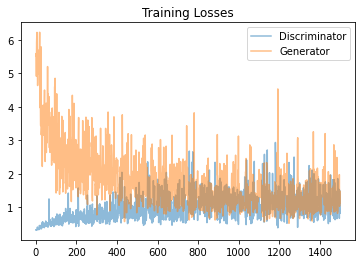

In [37]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [38]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [39]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

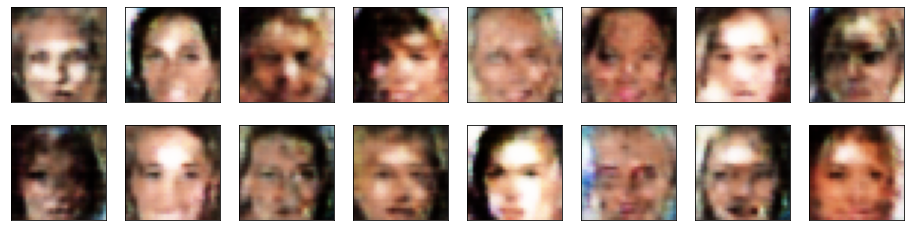

In [40]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.